## Получение эмбеддингов пены с помощью encodera от VAE

эмбеддинги пены нужны для их дальшейшей кластеризации

- loss: 
  - MSE with pixel-wize sotfmax loss with weights
  - если пиксель белый (>0.9), то он вносит свой вклад с коэффициентом 5, иначе - с коэфф 1

In [ ]:
import os
import sys
sys.stdout.flush()
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split 
import cv2
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import albumentations as A
from torchsummary import summary

def see_plot(pict, color='gray', size=(4,4)):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    #plt.grid()
    plt.show()
    

#print(cv2.__version__) #4.5.1
path_to_video1 = '/media/laggg/flotation_nornik/dataset1-1/'
path_to_video2 = '/media/laggg/flotation_nornik/dataset1-2/'

## Подготовим данные: нарежем кадры пены в отдельную папку для обучения, подготовим загрузчики батчей в нейронную сеть:

In [2]:
# нарежем кадры в отдельную папку

#!mkdir all_frames

#for x in os.listdir(path_to_video1):
#    print(x)
#    path_to_video = path_to_video1+x
#    cap = cv2.VideoCapture(path_to_video)
#    i=0
#    while True:
#        ret,frame=cap.read()
#        if not ret:
#            break
#        gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#        gray_img = gray_img[gray_img.shape[0]//4:gray_img.shape[0]//2,gray_img.shape[1]//4:3*gray_img.shape[1]//4]
#        p = cv2.resize(gray_img, (224, 224), interpolation=cv2.INTER_AREA)
#        cv2.imwrite(all_frames_dir+'/{}_f_{}.jpg'.format(x,i), p)
#        i+=1
        
#for x in os.listdir(path_to_video2):
#    print(x)
#    path_to_video = path_to_video2+x
#    cap = cv2.VideoCapture(path_to_video)
#    i=0
#    while True:
#        ret,frame=cap.read()
#        if not ret:
#            break
#        gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#        gray_img = gray_img[gray_img.shape[0]//4:gray_img.shape[0]//2,gray_img.shape[1]//4:3*gray_img.shape[1]//4]
#        p = cv2.resize(gray_img, (224, 224), interpolation=cv2.INTER_AREA)
#        cv2.imwrite(all_frames_dir+'/{}_f_{}.jpg'.format(x,i), p)
#        i+=1

#print(len(os.listdir(all_frames_dir))) #91919

In [3]:
# cvs Dataset

df = pd.DataFrame({'img_path': os.listdir(all_frames_dir)})
df['video'] = df['img_path'].apply(lambda x: x.split('.ts')[0])
df['frame'] = df['img_path'].apply(lambda x: x.split('.ts')[1][1:])

# составим валидационный датасет из видео: 'F1_1_3_1', 'F1_1_5_1', 'F2_2_3_1', 'F4_1_1_2', 'F7_2_1_1'
df['train'] = df['video'].apply(lambda x: 0 if x in ['F1_1_3_1', 'F1_1_5_1', 'F2_2_3_1', 'F4_1_1_2', 'F7_2_1_1'] else 1)
df_train = df[df.train==1].iloc[::4, :]#.sample(64)
df_val = df[df.train==0].iloc[::4, :]#.sample(32)
#df_val.to_csv('df_val.csv', index=False)
print(df.shape,df_train.shape,df_val.shape)
df.head()

(91919, 4) (20975, 4) (2006, 4)


,img_path,video,frame,train
0,F7_1_1_1.ts_f_703.jpg,F7_1_1_1,f_703.jpg,1
1,F1_2_5_1.ts_f_576.jpg,F1_2_5_1,f_576.jpg,1
2,F5_1_1_1.ts_f_611.jpg,F5_1_1_1,f_611.jpg,1
3,F1_2_2_2.ts_f_1044.jpg,F1_2_2_2,f_1044.jpg,1
4,F2_1_1_1.ts_f_1317.jpg,F2_1_1_1,f_1317.jpg,1


<class 'numpy.ndarray'> (224, 224)


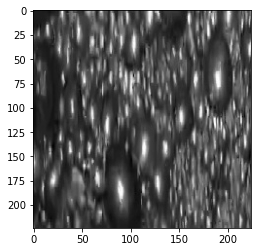

In [5]:
p = cv2.imread(all_frames_dir+df['img_path'][150], cv2.IMREAD_UNCHANGED)
print(type(p), p.shape) # np.uint8 [0.255]
see_plot(p)

In [6]:
# DataLoader
class SurvivDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        super().__init__()
        self.df = dataframe
        self.transform = transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        vid_name, frame, _, _ = self.df[idx]
        path = all_frames_dir+self.df[idx][0]
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
        if self.transform is not None:
            image = self.transform(image)
        return image
    
    
transformer = transforms.Compose([
    #A.HorizontalFlip(p=0.5),
    #A.RandomRotate90(),
    #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    transforms.ToTensor(),
])

my_batch = 16

train_data = SurvivDataset(df_train.values, transforms=transformer)
train_dataloader = DataLoader(train_data, batch_size=my_batch, shuffle=True)

test_data = SurvivDataset(df_val.values, transforms=transformer)
test_dataloader = DataLoader(test_data, batch_size=my_batch, shuffle=True)

torch.cuda.empty_cache()

## Визуализируем батч

torch.Size([16, 1, 224, 224])


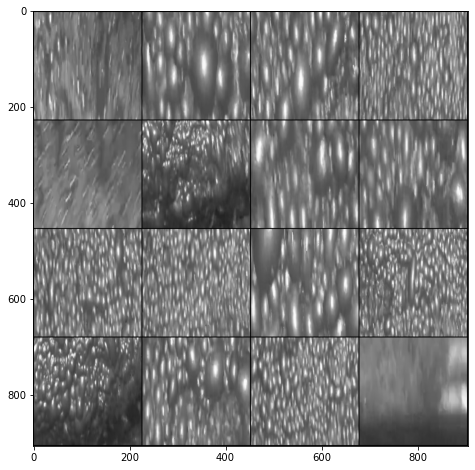

In [7]:
def plot_samples_on_epoch(samples, decoded=None):
    if decoded is not None:
    #plt.figure(figsize=(20, 20))
        f, axarr = plt.subplots(2,1, figsize=(8, 8))
        grid_img = torchvision.utils.make_grid(samples, nrow=4)
        axarr[0].imshow(grid_img.permute(1, 2, 0))
        grid_decoded = torchvision.utils.make_grid(decoded, nrow=4)
        axarr[1].imshow(grid_decoded.permute(1, 2, 0))
        plt.show();
    else:
        plt.figure(figsize=(8, 8))
        grid_img = torchvision.utils.make_grid(samples, nrow=4)
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.show();
        
sample = iter(test_dataloader).next()
print(sample.shape)
plot_samples_on_epoch(sample)

## Архитектура VAE

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, n_channels, h, w):
        super().__init__()
        self.channels = n_channels
        self.h = h
        self.w = w
        
    def forward(self, x):
        x = x.view(x.size(0), self.channels, self.h, self.w)
        return x
#====================================================================================================================

class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, output_shape=1024):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=hidden_channels,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels*2,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels*2,out_channels=hidden_channels*2,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels*2,out_channels=hidden_channels,kernel_size=3,stride=2,padding=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.linear = nn.Linear(in_features= hidden_channels * 14 * 14, out_features=output_shape)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        #x = self.linear(x)
        return x
#===================================================================================================================    
    
class Decoder(nn.Module):
    def __init__(self, in_shape=128, out_shape=1024, hidden_channels=64, out_channels=1): # 256
        super().__init__()
        self.fc = nn.Linear(in_features=in_shape, out_features=hidden_channels * 14 * 14)
        self.unflatten = UnFlatten(hidden_channels, 14, 14)

        self.relu = nn.ReLU()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels,out_channels=hidden_channels*2,
                               kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_channels*2,out_channels=hidden_channels*2,
                               kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_channels*2,out_channels=hidden_channels,
                               kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_channels,out_channels=out_channels,
                               kernel_size=4,stride=2,padding=1),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

In [9]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, encoder_output_shape=1024, latent_size=128): # 256
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.fc_encoder_mu = nn.Linear(in_features=12544,out_features=latent_size)
        self.fc_encoder_log_var = nn.Linear(in_features=12544,out_features=latent_size)
        
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_encoder_mu(h), self.fc_encoder_log_var(h)
        return mu, log_var
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def reparametrise(self, mu, log_var):
        if self.training:
            std_dev = torch.exp(0.5 * log_var)
            epsilon = torch.rand_like(std_dev)
            return epsilon.mul(std_dev).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, log_var = self.encode(x)
        z_latent = self.reparametrise(mu, log_var)
        return self.decode(z_latent), mu, log_var, z_latent
#===================================================================================================================    
def loss_function(recon_x, x, mu, logvar, KL_WEIGHT=0.5):
    
    MSE = F.mse_loss(recon_x, x, reduction='none') # 'sum'
    weights = torch.ones(x.shape)+(x>=0.85).type(torch.DoubleTensor)*4 # koeffs 1 and 10
    MSE = MSE*weights.to('cuda:1')
    MSE = torch.sum(MSE)
    MSE = torch.div(MSE,torch.numel(x)) # error in each pixel
    
    KLD = -KL_WEIGHT * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = torch.div(KLD,x.shape[0]) # error in each object
    
    return MSE+KLD
#===================================================================================================================
#доп метрика, на которую будем смотреть
def MSE_metric(recon_x, x):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = torch.div(MSE,torch.numel(x)) # error in each pixel
    return MSE
#===================================================================================================================

## Обучение VAE

In [108]:
params = {
    'EPOCHS': 12,
    'N_CHANNELS':1,
    'CONV_HIDDEN_DIM':64,
    'ENCODER_OUTPUT_SHAPE': 1024,
    'Z_LATENT_SHAPE': 128, #256
    'KL_WEIGHT': 0.5,
    'DEVICE': 'cuda:1' if torch.cuda.is_available() else 'cpu',
    #'DEVICE1': 'cuda:1'
}


encoder = Encoder()#.to(params['DEVICE'])
#summary(encoder, (1, 224, 224))
decoder = Decoder()#.to(params['DEVICE'])
#summary(decoder, (1, 128)) # 256
vae = VAE(encoder, decoder).to(params['DEVICE'])
#summary(vae, (1, 224, 224))

In [109]:
trainloss_ts = []
valloss_ts = []
valmetr_ts = []

def train_model(model, train_iterator, val_iterator, loss_func, metric, optimizer, params, sample, lr_shed=None):
    
    model.train()
    for i in range(params['EPOCHS']):
        print('===' * 10)
        print(f'EPOCH: [{i + 1}]/[{params["EPOCHS"]}]')
        print('===' * 10)
        print('lr:',optimizer.param_groups[0]['lr'])
        time.sleep(0.2)
        train_loss = 0.0
        for idx, img in enumerate(tqdm(train_iterator)):
            optimizer.zero_grad()
            img = img.to(params['DEVICE'])
            decoded_output, mu, log_var, z = model(img)
            loss = loss_func(decoded_output, img, mu, log_var, params['KL_WEIGHT'])
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        time.sleep(0.2)
        
        if lr_shed is not None:
            if (i+1) % 5 == 0:
                lr_shed.step()
        if i >= 1: # or train_loss<=x or val_loss<=y
            output_model_file = './trained_models/VAE_v1_{}epoch.pth'.format(i+1)
            model_to_save = model.module if hasattr(model, 'module') else model
            torch.save(model_to_save.state_dict(), output_model_file)
                
        train_loss = round(train_loss / len(train_iterator),4)
        val_loss, val_metric = eval_model(model, val_iterator, loss_func, metric, params, sample, i)
        trainloss_ts.append(train_loss)
        valloss_ts.append(val_loss)
        valmetr_ts.append(val_metric)
        print(trainloss_ts[-1])
        print(valloss_ts[-1])
        print(valmetr_ts[-1])

        
def eval_model(model, val_iterator, loss_func, metric, params, sample, epoch_num):
    model.eval()
    total_loss = 0.0
    total_metric = 0.0
    with torch.no_grad():
        time.sleep(0.2)
        for idx, img in enumerate(tqdm(val_iterator)):
            img = img.to(params['DEVICE'])
            decoded_output, mu, log_var, z = model(img)
            loss = loss_func(decoded_output, img, mu, log_var, params['KL_WEIGHT'])
            metr = metric(decoded_output, img)
            total_loss += loss.item()
            total_metric += metr.item()
        time.sleep(0.2)
        
    total_loss = round(total_loss / len(val_iterator),4)
    total_metric = round(total_metric / len(val_iterator),4)
    return total_loss,total_metric

In [110]:
loss_func = loss_function
optimizer = optim.Adam(vae.parameters(), lr=1e-4) # 1:3=1e-4, 4:6=1e-5, 7:9=1e-6, 10:12=1e-7
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.1)

train_model(vae, train_dataloader, test_dataloader, loss_func, MSE_metric, optimizer, params, sample, scheduler)

EPOCH: [1]/[12]
lr: 0.0001


100%|██████████| 126/126 [00:02<00:00, 58.78it/s]


0.0331
0.0346
0.0262
EPOCH: [2]/[12]
lr: 0.0001


100%|██████████| 126/126 [00:02<00:00, 61.36it/s]


0.033
0.0296
0.0195
EPOCH: [3]/[12]
lr: 0.0001


100%|██████████| 126/126 [00:02<00:00, 60.98it/s]


0.0316
0.0215
0.0123
EPOCH: [4]/[12]
lr: 0.0001


100%|██████████| 126/126 [00:02<00:00, 61.60it/s]


0.022
0.0171
0.0099
EPOCH: [5]/[12]
lr: 0.0001


100%|██████████| 126/126 [00:02<00:00, 60.68it/s]


0.0188
0.0157
0.0095
EPOCH: [6]/[12]
lr: 1e-05


100%|██████████| 126/126 [00:02<00:00, 61.25it/s]


0.0178
0.0154
0.0094
EPOCH: [7]/[12]
lr: 1e-05


100%|██████████| 126/126 [00:02<00:00, 60.99it/s]


0.0176
0.0153
0.0092
EPOCH: [8]/[12]
lr: 1e-05


100%|██████████| 126/126 [00:02<00:00, 60.93it/s]


0.0174
0.0152
0.0092
EPOCH: [9]/[12]
lr: 1e-05


100%|██████████| 126/126 [00:02<00:00, 60.69it/s]


0.0172
0.015
0.0091
EPOCH: [10]/[12]
lr: 1e-05


100%|██████████| 126/126 [00:02<00:00, 61.07it/s]


0.017
0.0149
0.0092
EPOCH: [11]/[12]
lr: 1.0000000000000002e-06


100%|██████████| 126/126 [00:02<00:00, 60.76it/s]


0.0169
0.0149
0.0091
EPOCH: [12]/[12]
lr: 1.0000000000000002e-06


100%|██████████| 126/126 [00:02<00:00, 61.09it/s]


0.0169
0.0149
0.0091


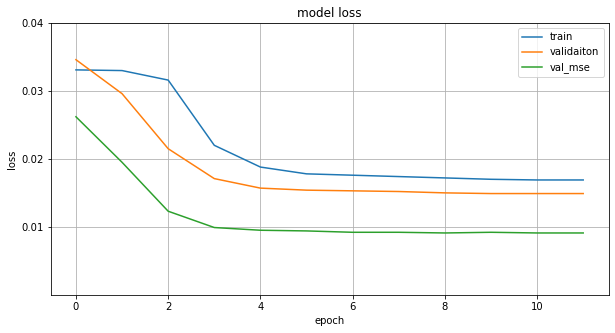

In [111]:
# v1 0.091
plt.figure(figsize=(10,5));
plt.plot(trainloss_ts)
plt.plot(valloss_ts)
plt.plot(valmetr_ts)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yticks([0.01,0.02,0.03,0.04])
plt.ylim([0.0,0.04])
plt.legend(['train', 'validaiton', 'val_mse']) #, loc='upper left'
plt.grid()
plt.show()

# Load trained model and Visualization 

In [11]:
a = Encoder()
b = Decoder()
my_model = VAE(a, b)

path_load_model = './trained_models/VAE_v1_12epoch.pth'
my_model.load_state_dict(torch.load(path_load_model, map_location=torch.device(params['DEVICE'])))

<All keys matched successfully>

<class 'torch.Tensor'> torch.Size([16, 1, 224, 224])


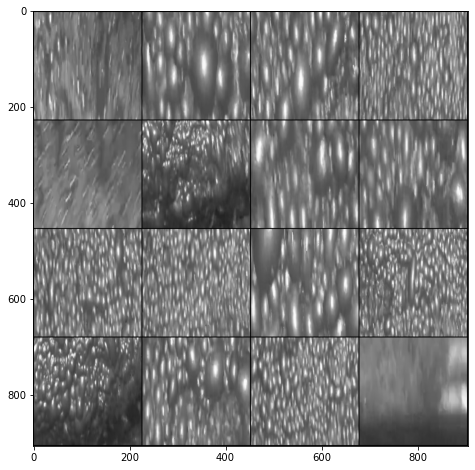

In [12]:
print(type(sample), sample.shape)
plot_samples_on_epoch(sample)

torch.Size([16, 1, 224, 224])


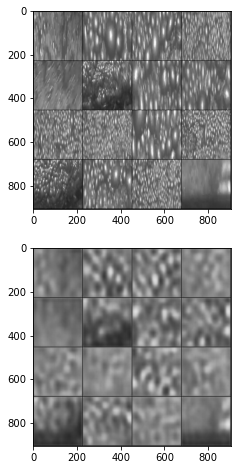

In [13]:
def model_inference_batch(model, batch, params, to_cpu=True):
    model.eval()
    with torch.no_grad():
        #batch = batch.to(params['DEVICE'])
        sample_reconstructed, mu, log_var, z = model(batch)
    if to_cpu:
        sample_reconstructed = sample_reconstructed#.detach().cpu().numpy()
        mu = mu.detach().cpu().numpy()
        log_var = log_var.detach().cpu().numpy()
        z = z.detach().cpu().numpy()
    return sample_reconstructed, mu, log_var, z


recon_sample, _, _, _ = model_inference_batch(my_model, sample, params)
recon_n = recon_sample.detach().cpu().numpy()
recon_n = torch.from_numpy(recon_n)
print(sample.shape)
plot_samples_on_epoch(sample, recon_n)

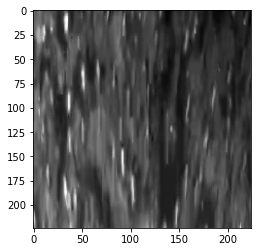

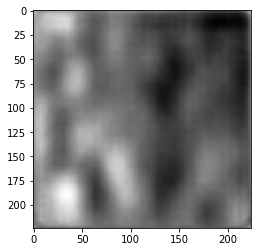

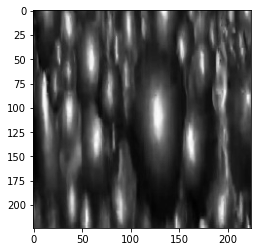

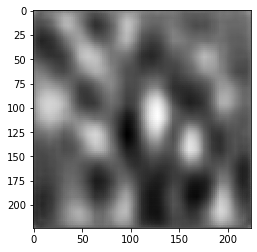

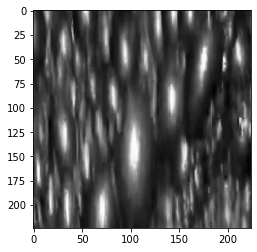

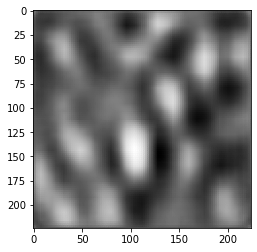

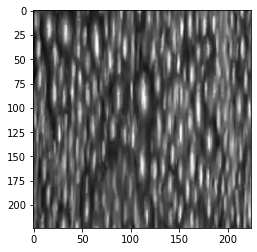

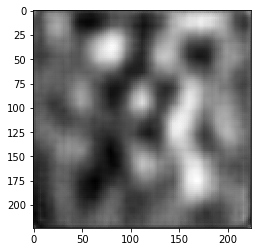

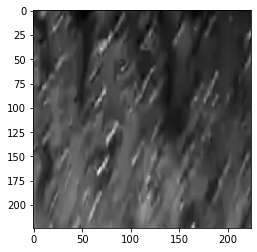

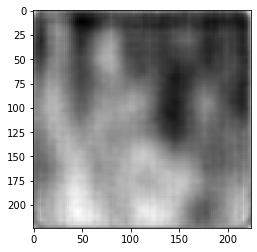

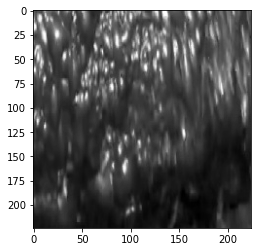

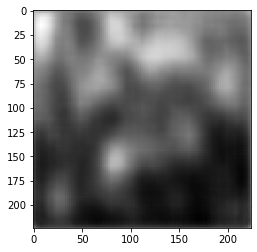

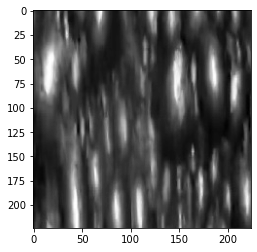

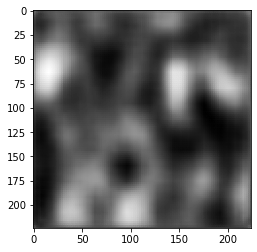

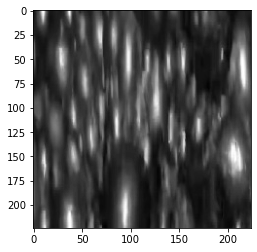

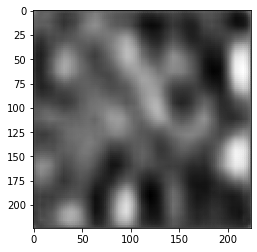

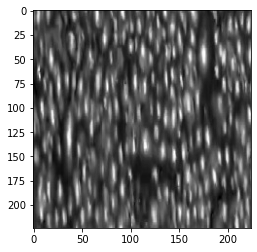

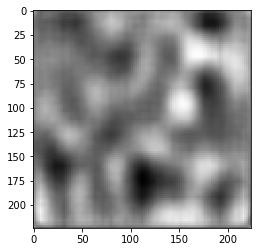

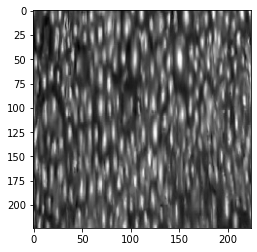

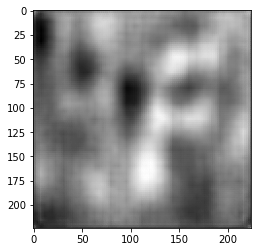

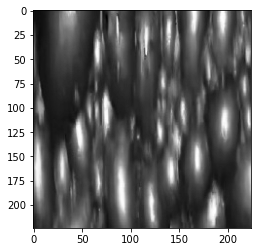

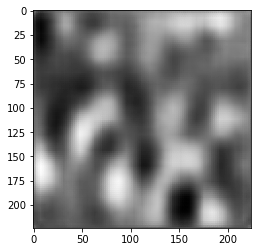

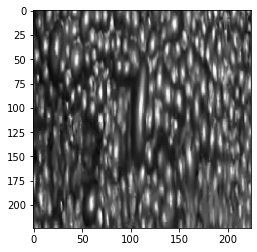

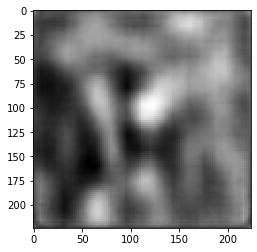

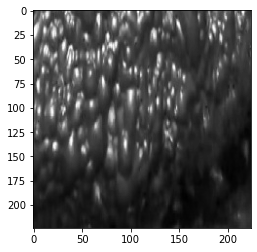

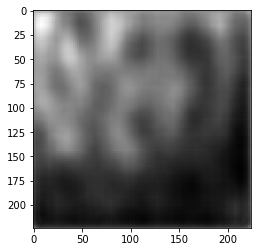

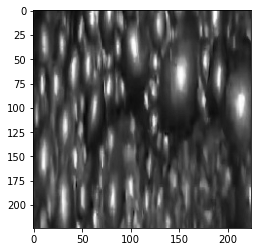

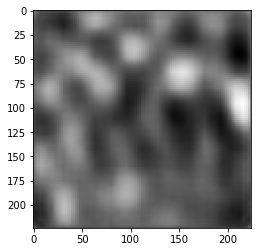

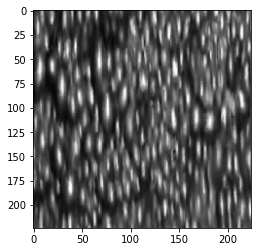

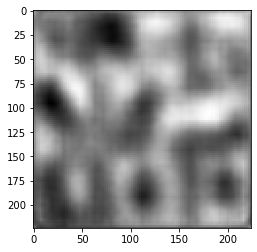

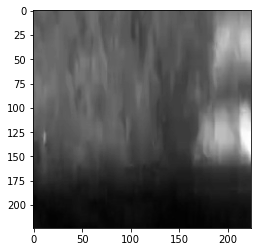

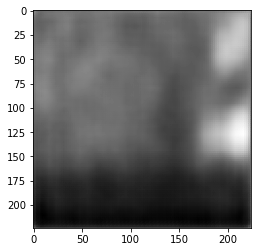

In [15]:
def model_inference_image(model, img, params, to_cpu=True):
    model.eval()
    with torch.no_grad():
        #img = img.to(params['DEVICE'])
        sample_reconstructed, mu, log_var, z = model(img)
    if to_cpu:
        sample_reconstructed = sample_reconstructed.detach().cpu().numpy()
        mu = mu.detach().cpu().numpy()
        log_var = log_var.detach().cpu().numpy()
        z = z.detach().cpu().numpy()
    return sample_reconstructed, mu, log_var, z


for i in range(16):
    img = sample[i].unsqueeze(dim=0)
    recon_sample = model_inference_image(my_model, img, params)[0]
    plt.imshow(img.squeeze(), cmap='gray');
    plt.show();
    plt.imshow(recon_sample.squeeze(), cmap='gray')
    plt.show();